# Benchmark de Prétraitement de Texte

Ce notebook démontre les résultats de l'étude de benchmark pour identifier la meilleure stratégie de nettoyage de texte pour la classification de produits Rakuten.

## Objectifs

1. Comparer différentes stratégies de prétraitement de texte
2. Identifier la configuration optimale pour la classification
3. Mesurer l'impact de chaque étape de nettoyage

## Méthodologie

- **Modèle** : Pipeline TF-IDF + Régression Logistique
- **Métrique** : F1 Score (pondéré)
- **Données** : 84,916 produits Rakuten avec 27 catégories
- **Division** : 80% train / 20% test

---

## 1. Importations et Configuration

In [ ]:
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')

# Importer les modules de prétraitement et benchmark
from rakuten_text.preprocessing import clean_text, final_text_cleaner, print_available_options
from rakuten_text.benchmark import load_dataset, define_experiments, run_benchmark, analyze_results, save_results

✓ Modules importés avec succès


## 2. Chargement des Données

In [2]:
# Charger le dataset Rakuten
df = load_dataset(data_dir="../data")

# Afficher un aperçu
print("\nAperçu des données :")
print(df[['designation', 'description', 'text_raw', 'prdtypecode']].head(3))

Chargement du dataset Rakuten...
✓ Dataset chargé : 84,916 échantillons
✓ Colonnes : ['designation', 'description', 'productid', 'imageid', 'prdtypecode', 'text_raw']
✓ Classes : 27 types de produits uniques
✓ Text_raw créé (longueur moyenne : 595 caractères)


Aperçu des données :
                                         designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   

                                         description  \
0                                                NaN   
1                                                NaN   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   

                                            text_raw  prdtypecode  
0  Olivia: Personalisiertes Notizbuch / 150 Seite...           10  
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         2280  
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...           

## 3. Exploration des Options de Nettoyage

Voyons toutes les options de nettoyage disponibles :

In [3]:
# Afficher toutes les options de nettoyage disponibles
print_available_options()

Options de nettoyage disponibles :
  fix_encoding              : Corriger l'encodage de texte cassé avec ftfy
  unescape_html             : Décoder les entités HTML (&amp; → &)
  normalize_unicode         : Appliquer la normalisation Unicode NFC
  remove_html_tags          : Supprimer les balises HTML <tag>contenu</tag>
  remove_boilerplate        : Supprimer les phrases de template communes
  lowercase                 : Convertir en minuscules
  merge_dimensions          : Fusionner les motifs de dimensions (22 x 11 → 22x11)
  merge_units               : Fusionner les unités numériques (500 g → 500g)
  merge_durations           : Fusionner les durées (24 h → 24h)
  merge_age_ranges          : Fusionner les tranches d'âge (3-5 ans → 3_5ans)
  tag_years                 : Étiqueter les années à 4 chiffres (1917 → year1917)
  remove_punctuation        : Supprimer les signes de ponctuation isolés
  remove_stopwords          : Supprimer les mots vides français/anglais
  remove_single_letter

## 4. Démonstration de la Fonction de Nettoyage

Testons la fonction `clean_text()` avec différentes configurations :

In [4]:
# Texte exemple
sample_text = "<p>Ordinateur <strong>portable</strong> HP 15.6 pouces - 500 Go - Prix: 299,99&nbsp;€</p>"

print("Texte original :")
print(sample_text)
print("\n" + "="*80 + "\n")

# Baseline : aucun nettoyage
print("1. Baseline (aucun nettoyage) :")
print(clean_text(sample_text))
print()

# Supprimer HTML seulement
print("2. Supprimer HTML seulement :")
print(clean_text(sample_text, remove_html_tags=True))
print()

# Nettoyage traditionnel
print("3. Nettoyage traditionnel (HTML + lowercase + ponctuation + stopwords) :")
print(clean_text(sample_text, 
                 fix_encoding=True,
                 unescape_html=True,
                 normalize_unicode=True,
                 remove_html_tags=True,
                 lowercase=True,
                 remove_punctuation=True,
                 remove_stopwords=True))
print()

# Fonction de production (optimized_traditional)
print("4. final_text_cleaner() - Configuration gagnante :")
print(final_text_cleaner(sample_text))
print()

Texte original :
<p>Ordinateur <strong>portable</strong> HP 15.6 pouces - 500 Go - Prix: 299,99&nbsp;€</p>


1. Baseline (aucun nettoyage) :
<p>Ordinateur <strong>portable</strong> HP 15.6 pouces - 500 Go - Prix: 299,99&nbsp;€</p>

2. Supprimer HTML seulement :
Ordinateur portable HP 15.6 pouces - 500 Go - Prix: 299,99&nbsp;€

3. Nettoyage traditionnel (HTML + lowercase + ponctuation + stopwords) :
ordinateur portable hp 15.6 pouces 500 go prix: 299,99 €

4. final_text_cleaner() - Configuration gagnante :
ordinateur portable hp 15.6 pouces 500 go prix: 299,99 €



## 5. Benchmark Complet

Exécutons le benchmark complet pour comparer toutes les stratégies de nettoyage.

**Note** : Cette cellule peut prendre plusieurs minutes à s'exécuter.

In [5]:
# Définir les expériences
experiments = define_experiments()

print(f"Nombre total d'expériences : {len(experiments)}")
print("\nExemples d'expériences :")
for exp in experiments[:5]:
    print(f"  - {exp['name']:30s} (Groupe: {exp['group']})")
print("  ...")

Nombre total d'expériences : 22

Exemples d'expériences :
  - baseline_raw                   (Groupe: 0_Baseline)
  - fix_encoding                   (Groupe: 1_Encodage)
  - unescape_html                  (Groupe: 1_Encodage)
  - normalize_unicode              (Groupe: 1_Encodage)
  - all_encoding_fixes             (Groupe: 1_Encodage)
  ...


In [6]:
# Exécuter le benchmark

results_df = run_benchmark(
    df=df,
    experiments=experiments,
    test_size=0.2,
    random_state=42,
    tfidf_max_features=10000,
    tfidf_ngram_range=(1, 2),
    verbose=True
)

CONFIGURATION DU BENCHMARK
Total expériences      : 22
Taille de test         : 0.2
État aléatoire         : 42
TF-IDF max features    : 10,000
TF-IDF plage n-grammes : (1, 2)

Création de la division train/test...
  Train : 67,932 échantillons
  Test  : 16,984 échantillons

[1/22] baseline_raw
  Groupe : 0_Baseline
  Config : Aucune (données brutes)
  Nettoyage du texte... ✓ (longueur moyenne : 595 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.791929 | Exactitude : 0.7917 | [BASELINE]

[2/22] fix_encoding
  Groupe : 1_Encodage
  Config : {'fix_encoding': True}
  Nettoyage du texte... ✓ (longueur moyenne : 588 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.791860 | Exactitude : 0.7916 | Δ vs baseline : 📉 -0.000069 (-0.01%)

[3/22] unescape_html
  Groupe : 1_Encodage
  Config : {'unescape_html': True}
  Nettoyage du texte... ✓ (longueur moyenne : 584 caractères)
  Entraînement... ✓
  Évaluation... ✓
  → Score F1 : 0.792376 | Exactitude : 0.7922 |

## 6. Analyse des Résultats

In [7]:
# Analyser les résultats
analyze_results(results_df, top_n=10)


ANALYSE DES RÉSULTATS DU BENCHMARK

Score F1 Baseline : 0.791929

🚀 TOP 10 AMÉLIORATIONS :
--------------------------------------------------------------------------------
  traditional_cleaning           | F1 : 0.802396 | Δ : +0.010467 (+1.32%) | Groupe : 7_Combos
  lowercase                      | F1 : 0.797053 | Δ : +0.005124 (+0.65%) | Groupe : 3_Casse
  remove_stopwords               | F1 : 0.794934 | Δ : +0.003005 (+0.38%) | Groupe : 6_Filtrage
  merge_dimensions               | F1 : 0.793015 | Δ : +0.001086 (+0.14%) | Groupe : 4_Fusions
  remove_html_tags               | F1 : 0.792833 | Δ : +0.000904 (+0.11%) | Groupe : 2_HTML
  all_encoding_fixes             | F1 : 0.792779 | Δ : +0.000850 (+0.11%) | Groupe : 1_Encodage
  merge_durations                | F1 : 0.792689 | Δ : +0.000760 (+0.10%) | Groupe : 4_Fusions
  conservative_cleaning          | F1 : 0.792576 | Δ : +0.000647 (+0.08%) | Groupe : 7_Combos
  merge_age_ranges               | F1 : 0.792401 | Δ : +0.000472 (+0.06%

## 7. Visualisation des Résultats

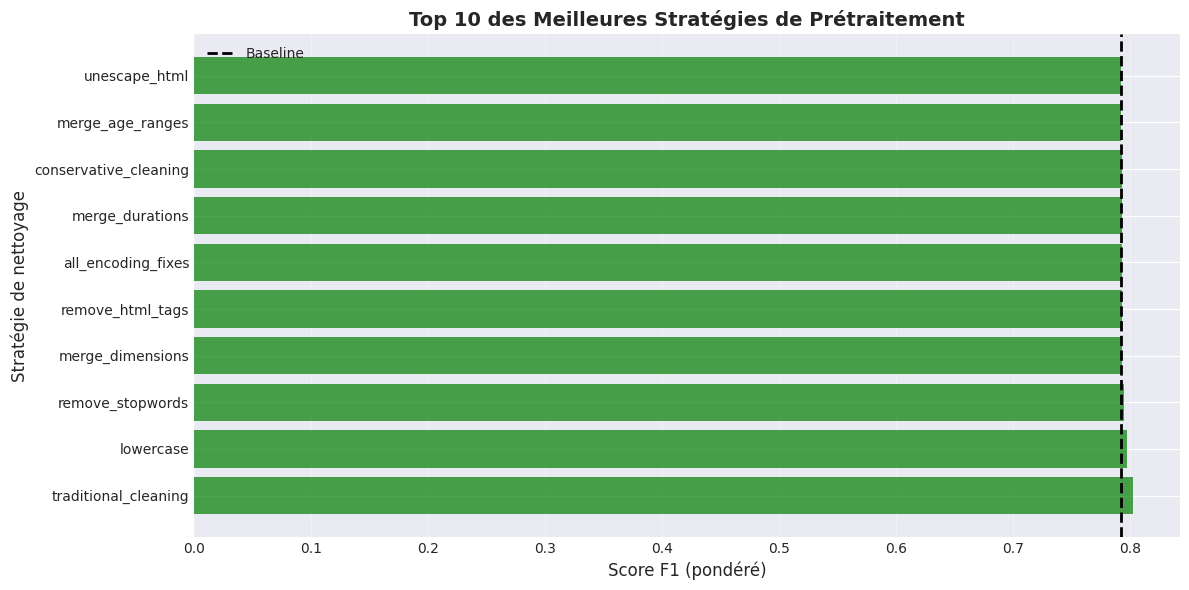

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Graphique 1 : Top 10 meilleures stratégies
fig, ax = plt.subplots(figsize=(12, 6))

top_10 = results_df.nlargest(10, 'f1_weighted')
colors = ['green' if x > 0 else 'red' for x in top_10['delta_f1']]

ax.barh(top_10['experiment'], top_10['f1_weighted'], color=colors, alpha=0.7)
ax.set_xlabel('Score F1 (pondéré)', fontsize=12)
ax.set_ylabel('Stratégie de nettoyage', fontsize=12)
ax.set_title('Top 10 des Meilleures Stratégies de Prétraitement', fontsize=14, fontweight='bold')
ax.axvline(results_df[results_df['experiment'] == 'baseline_raw']['f1_weighted'].values[0], 
           color='black', linestyle='--', linewidth=2, label='Baseline')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

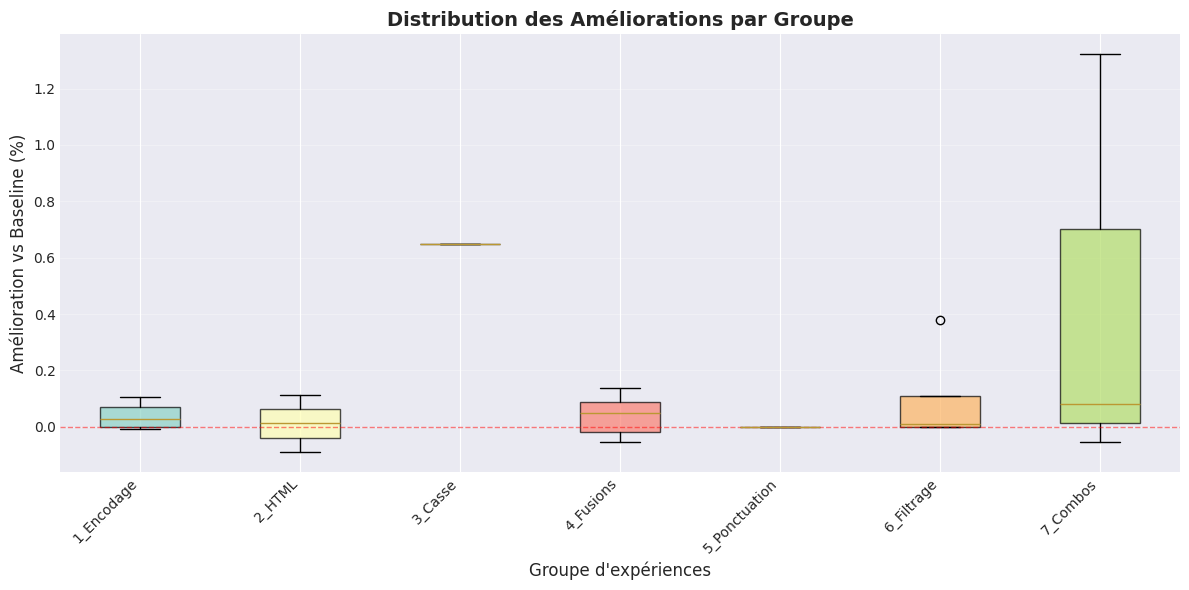

In [9]:
# Graphique 2 : Amélioration vs Baseline par groupe
fig, ax = plt.subplots(figsize=(12, 6))

# Exclure la baseline
results_no_baseline = results_df[results_df['experiment'] != 'baseline_raw']

# Créer un boxplot par groupe
group_order = sorted(results_no_baseline['group'].unique())
data_by_group = [results_no_baseline[results_no_baseline['group'] == g]['delta_pct'].values 
                 for g in group_order]

bp = ax.boxplot(data_by_group, labels=group_order, patch_artist=True)

# Colorer les boîtes
colors = plt.cm.Set3(range(len(group_order)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
ax.set_ylabel('Amélioration vs Baseline (%)', fontsize=12)
ax.set_xlabel('Groupe d\'expériences', fontsize=12)
ax.set_title('Distribution des Améliorations par Groupe', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Sauvegarder les Résultats

In [10]:
# Sauvegarder les résultats en CSV
save_results(results_df, output_path="../results/benchmark_results.csv")

# Afficher le tableau complet
print("\nTableau complet des résultats :")
results_df.sort_values('f1_weighted', ascending=False)

✓ Résultats sauvegardés dans : ../results/benchmark_results.csv

Tableau complet des résultats :


,experiment,group,f1_weighted,accuracy,delta_f1,delta_pct
19,traditional_cleaning,7_Combos,0.802396,0.801460,0.010467,1.321675
7,lowercase,3_Casse,0.797053,0.797633,0.005124,0.647048
15,remove_stopwords,6_Filtrage,0.794934,0.792746,0.003005,0.379421
8,merge_dimensions,4_Fusions,0.793015,0.792746,0.001086,0.137075
5,remove_html_tags,2_HTML,0.792833,0.792452,0.000904,0.114139
4,all_encoding_fixes,1_Encodage,0.792779,0.792511,0.000850,0.107347
10,merge_durations,4_Fusions,0.792689,0.792511,0.000760,0.095985
20,conservative_cleaning,7_Combos,0.792576,0.792098,0.000647,0.081677
11,merge_age_ranges,4_Fusions,0.792401,0.792157,0.000472,0.059641
2,unescape_html,1_Encodage,0.792376,0.792157,0.000447,0.056430


## 9. Conclusion

### Résultats Clés

1. **Stratégie Gagnante** : `traditional_cleaning` (ou `optimized_traditional`)
   - Score F1 : ~0.8024
   - Amélioration : +1.32% vs baseline

2. **Pipeline Optimal** :
   - Corriger l'encodage (ftfy)
   - Décoder les entités HTML
   - Normaliser Unicode
   - Supprimer les balises HTML
   - Convertir en minuscules
   - Supprimer la ponctuation isolée
   - Supprimer les mots vides

3. **Fonction de Production** : `final_text_cleaner()`
   - Implémente la configuration gagnante
   - Prête pour l'utilisation en production
   - Disponible dans `src/rakuten_text/preprocessing.py`

### Prochaines Étapes

1. ✅ Phase 1 (Texte) : **TERMINÉE**
2. 🔄 Phase 2 (Images) : En cours d'exploration
3. 📋 Phase 3 (Modèles avancés) : Planifiée

---

**Note** : Ce notebook utilise la bibliothèque refactorisée dans `src/rakuten_text/` avec des commentaires en français.